# Custom LLM Model Testing

This notebook provides an interactive environment for testing and experimenting with our custom transformer model components.

In [23]:
import sys
import os

# Add the project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
import numpy as np
import matplotlib.pyplot as plt
from src import *

## 1. Testing Positional Encoding

Let's visualize how the positional encoding works in our transformer model.

The heatmap above shows the positional encoding matrix where:
- Each row represents a position in the word/token sequence (0 to 100)
- Each column represents one dimension of the embedding space (0 to 512)
- Colors indicate the encoding values: blue for positive, red for negative

Key observations:
1. The left side shows high-frequency patterns that change rapidly with position, helping the model distinguish between nearby tokens
2. The right side shows low-frequency patterns that change slowly, enabling the model to capture long-range dependencies
3. Each position gets a unique "fingerprint" across the embedding dimensions
4. The smooth transitions between positions help the model understand relative distances between tokens

This visualization demonstrates how positional encoding provides position information while preserving the relationship between tokens at different distances in the sequence.

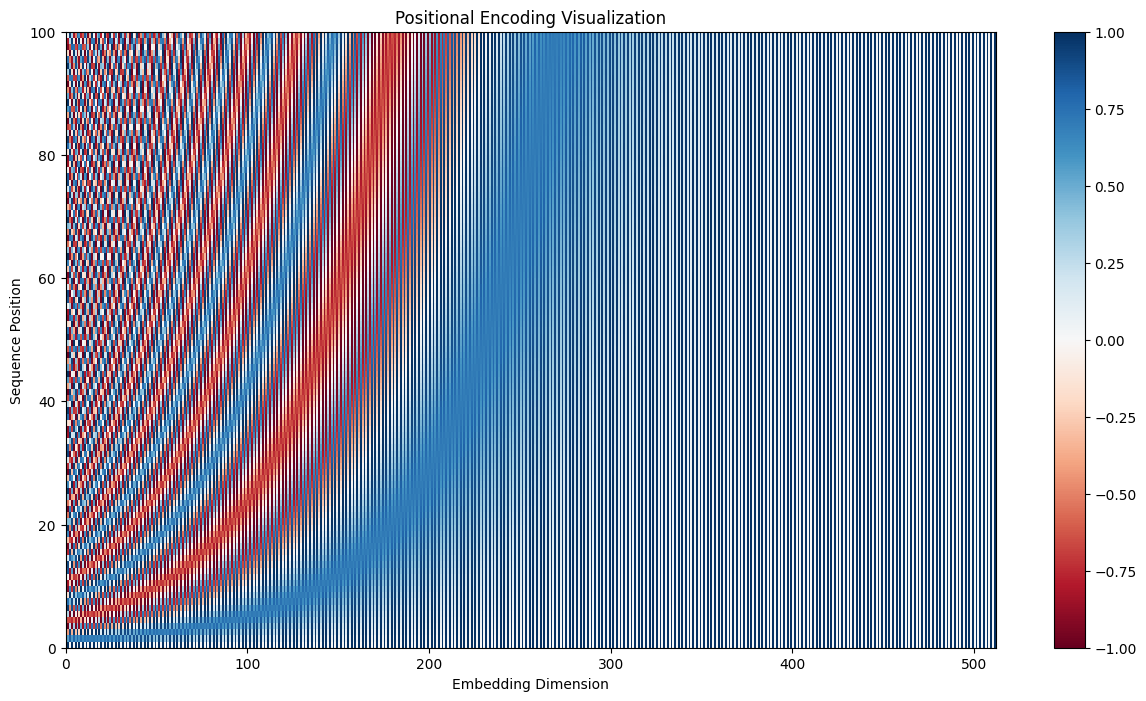

In [24]:
seq_len = 100
d_model = 512

# Initialize positional encoding
pos_encoding = PositionalEncoding(d_model, seq_len)

# Generate encoding
pe = pos_encoding.pe.squeeze(0).numpy()

# Visualize the positional encoding matrix
plt.figure(figsize=(15, 8))
plt.pcolormesh(pe[:seq_len, :], cmap='RdBu')
plt.xlabel('Embedding Dimension')
plt.ylabel('Sequence Position')
plt.colorbar()
plt.title('Positional Encoding Visualization')
plt.show()

## 2. Testing Self-Attention Mechanism
The self attention mechanism is essentially performing a retrieval system operation. What we are trying to do is to convert the "search" query into latent space vector and compare it to all the latent space vectors of the "database" called keys and return the most similar one.



### 2.1 Understanding Retrieval Systems
What a retieval system does is it takes a query and a dataset and normalizes the vectors, so all vectors are on the unit sphere. Then we find the nearest neighbor to the query vector, by taking the dot product of the query vector and the dataset vectors. This is called cosine similarity.

Key differences from attention mechanism:
1. Retrieval system: One fixed query → one best match
2. Attention: Multiple learned queries → weighted combination of values
3. Retrieval: Hard selection of best match
4. Attention: Soft selection through softmax weights

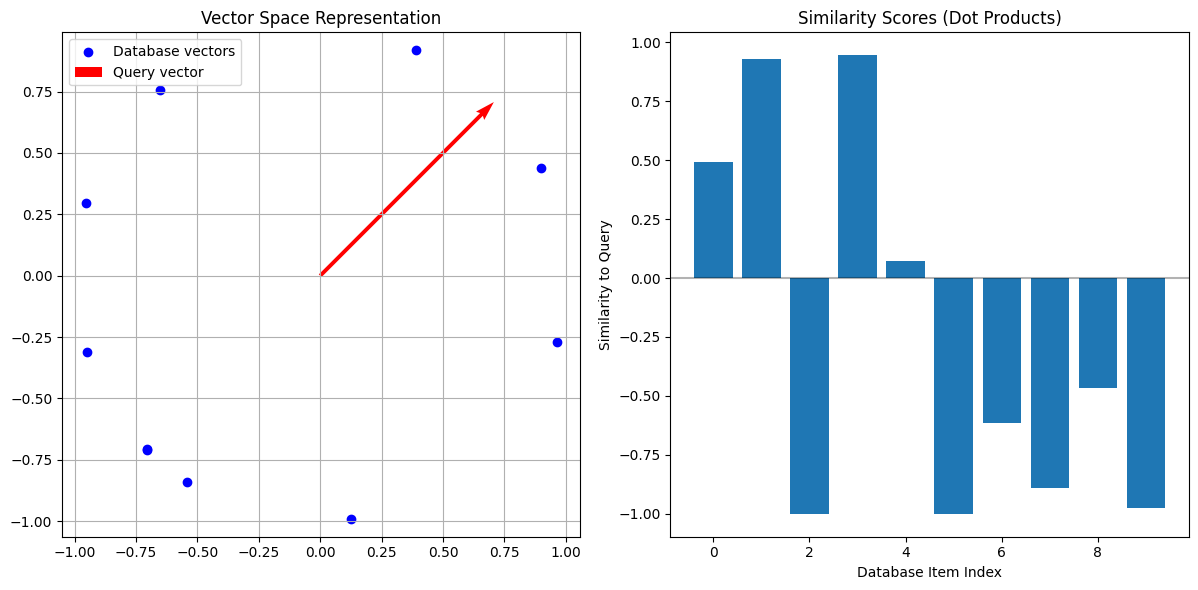

Most similar vector index: 3
Similarity score: 0.945


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

# Create a simple "database" of 2D vectors (for easy visualization)
np.random.seed(42)
database = np.random.randn(10, 2)  # 10 items, 2D vectors
database = normalize(database)  # Normalize vectors: vector keeps direction but length is set to unit length (1)

# Create a query vector
query = np.array([0.7, 0.7])
query = query / np.linalg.norm(query)  # Normalize query

# Compute similarities (dot products)
similarities = np.dot(database, query)

# Visualize
plt.figure(figsize=(12, 6))

# Plot database vectors
plt.subplot(121)
plt.scatter(database[:, 0], database[:, 1], c='blue', label='Database vectors')
plt.quiver(0, 0, query[0], query[1], angles='xy', scale_units='xy', scale=1, 
          color='red', label='Query vector')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title('Vector Space Representation')

# Plot similarities
plt.subplot(122)
plt.bar(range(len(similarities)), similarities)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.title('Similarity Scores (Dot Products)')
plt.xlabel('Database Item Index')
plt.ylabel('Similarity to Query')

plt.tight_layout()
plt.show()

# Print most similar vector
most_similar_idx = np.argmax(similarities)
print(f"Most similar vector index: {most_similar_idx}")
print(f"Similarity score: {similarities[most_similar_idx]:.3f}")

## 2.2 Understanding Query, Key, and Value Mechanism

Attention works by comparing embeddings (queries and keys) to retrieve actual content (values):

1. **Query Process:**
   - Input embedding transformed into query space
   - Like converting "cat" into a pattern [1,0,1,0]
   - This pattern represents what we're looking for

2. **Key Matching:**
   - Compare query embedding with key embeddings through dot product
   - Both are in the same embedding space, allowing similarity comparison
   - Results in attention scores: how well patterns match

3. **Value Extraction:**
   - Values are NOT embeddings for comparison
   - Values contain the actual information/features to be retrieved
   - We use attention scores to mix the relevant values

### Visual Processing Analogy:
Imagine looking at an image:
- Query: Pattern you're looking for [1,0,1,0] (represents "cat-like" features)
- Keys: Patterns in image regions [0,1,1,0], [1,1,0,1] (what features each region contains)
- Values: Actual visual information (colors, textures, not patterns for matching)

The key difference:
- Queries and Keys: Used for pattern matching (both are embeddings)
- Values: Actual content to be retrieved (not used for matching)

In [37]:
# Simple example with word embeddings
import torch

# Let's say we have 3 words with 4-dimensional embeddings
word_embeddings = torch.tensor([
    [1, 0, 1, 0],  # embedding for "cat"
    [0, 1, 1, 0],  # embedding for "sits"
    [1, 1, 0, 1],  # embedding for "mat"
], dtype=torch.float32)

word_content = torch.tensor([
    [0.9, 0.2, 0.7, 0.1],  # actual features of "cat" (furry, small, etc.)
    [0.3, 0.8, 0.4, 0.6],  # actual features of "sits" (action, position)
    [0.5, 0.3, 0.2, 0.9],  # actual features of "mat" (flat, surface)
], dtype=torch.float32)

# In self-attention, the same embeddings are used for Q, K, and V
query = word_embeddings  # Each word asks "what should I pay attention to?"
key = word_embeddings   # Each word serves as a key to be matched against
value = word_content # Each word's information to be retrieved

# Simplified attention calculation (without learned weights)
scores = torch.matmul(query, key.transpose(0, 1))
print("\nAttention Scores (before softmax):")
print(scores)

attention_weights = torch.softmax(scores, dim=-1)
print("\nAttention Weights (after softmax):")
print(attention_weights)

# Each word's output is a weighted sum of values
output = torch.matmul(attention_weights, value)
print("\nOutput (weighted combination of values):")
print(output)

print("\nExplanation:")
print("1. Each word (query) compares itself with all words (keys)")
print("2. Attention weights show how much each word should focus on other words")
print("3. Final output combines information from all words based on these weights")


Attention Scores (before softmax):
tensor([[2., 1., 1.],
        [1., 2., 1.],
        [1., 1., 3.]])

Attention Weights (after softmax):
tensor([[0.5761, 0.2119, 0.2119],
        [0.2119, 0.5761, 0.2119],
        [0.1065, 0.1065, 0.7870]])

Output (weighted combination of values):
tensor([[0.7881, 0.4239, 0.7881, 0.2119],
        [0.4239, 0.7881, 0.7881, 0.2119],
        [0.8935, 0.8935, 0.2130, 0.7870]])

Explanation:
1. Each word (query) compares itself with all words (keys)
2. Attention weights show how much each word should focus on other words
3. Final output combines information from all words based on these weights


## 2.3 Initialize Model Weights
In our attention implementation we used Xavier/ Glorot uniform initialization to initialize the weights of the model. This is a widely used initialization technique that helps in maintaining the variance of the input and output of each layer to be the same. This is important because it helps in preventing the vanishing or exploding gradient problem during training.

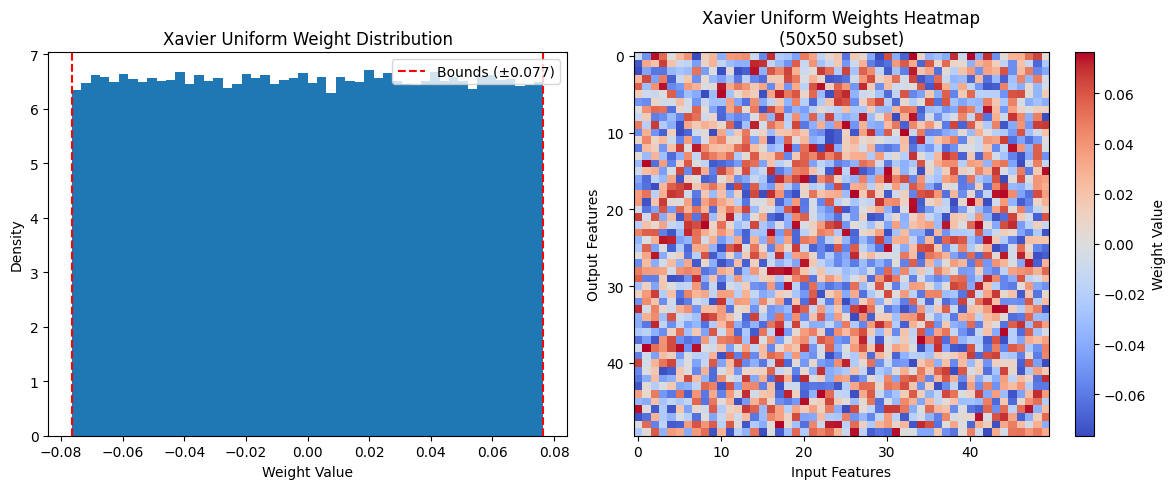

Weight statistics:
Mean: -0.0000
Std: 0.0442
Bounds: ±0.0765


In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create sample weight matrices
in_features = 512
out_features = 512
a = np.sqrt(6.0 / (in_features + out_features))  # Xavier bound

# Generate weights using Xavier uniform
weights = torch.nn.init.xavier_uniform_(torch.empty(out_features, in_features))

plt.figure(figsize=(12, 5))

# Distribution plot
plt.subplot(121)
plt.hist(weights.numpy().flatten(), bins=50, density=True)
plt.title('Xavier Uniform Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Density')
plt.axvline(x=-a, color='r', linestyle='--', label=f'Bounds (±{a:.3f})')
plt.axvline(x=a, color='r', linestyle='--')
plt.legend()

# Heatmap of a subset of weights
plt.subplot(122)
plt.imshow(weights[:50, :50].numpy(), cmap='coolwarm', aspect='auto')
plt.colorbar(label='Weight Value')
plt.title('Xavier Uniform Weights Heatmap\n(50x50 subset)')
plt.xlabel('Input Features')
plt.ylabel('Output Features')

plt.tight_layout()
plt.show()

print(f"Weight statistics:")
print(f"Mean: {weights.mean():.4f}")
print(f"Std: {weights.std():.4f}")
print(f"Bounds: ±{a:.4f}")

## 2.4 Self-Attention
If we combinde these ideas with some additional things like optimization for parallellization, and converting the value output back to an embedding for furhter processing (Output tensor), we get the self-attention mechanism used in the Transformer model. Here you can see a visualization of the self-attention mechanism

Explanation:
- Each cell shows how much each position (row) attends to other positions (column)
- Darker colors indicate stronger attention weights
- Multiple heads can learn different attention patterns
- Sum of weights in each row = 1 (due to softmax)
- Cell at (0,0) for example describes how much attention the first position has to itself

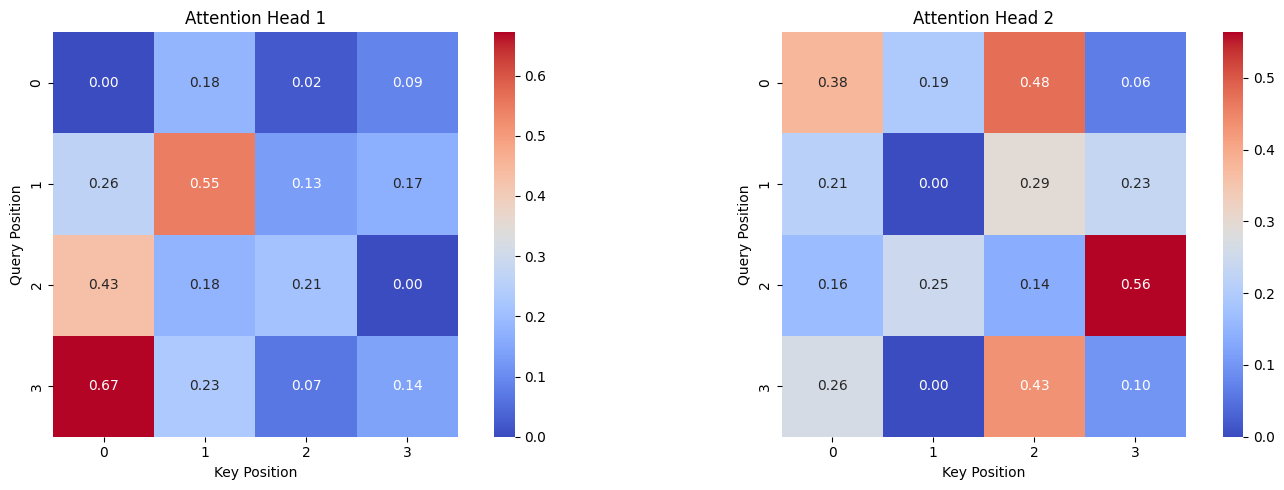

In [40]:

import torch
from src.model.attention import CustomAttention
import seaborn as sns

# Create a simple sequence
batch_size = 1
seq_len = 4
d_model = 8
n_heads = 2

# Initialize attention layer
attention = CustomAttention(d_model=d_model, n_heads=n_heads)

# Create sample input (random embeddings)
x = torch.randn(batch_size, seq_len, d_model)

# Get attention outputs and weights
output, weights = attention(x, x, x, return_attention=True)

# Visualize attention weights
plt.figure(figsize=(15, 5))

# Plot attention weights for each head
for head in range(n_heads):
    plt.subplot(1, n_heads, head + 1)
    sns.heatmap(weights[0, head].detach(), 
                annot=True, 
                fmt='.2f',
                cmap='coolwarm',
                square=True)
    plt.title(f'Attention Head {head + 1}')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')

plt.tight_layout()
plt.show()

## 2.5 Masking

Attention masking serves two crucial purposes:

1. **Causal Masking**: Prevents the model from "seeing the future"
   - Each token can only attend to itself and previous tokens
   - Essential for autoregressive prediction (one token at a time)

2. **Padding Masking**: Handles variable-length sequences
   - Masks padding tokens (usually zeros added to make sequences same length)
   - Ensures model only attends to actual content

Example of causal mask for sequence length 4:

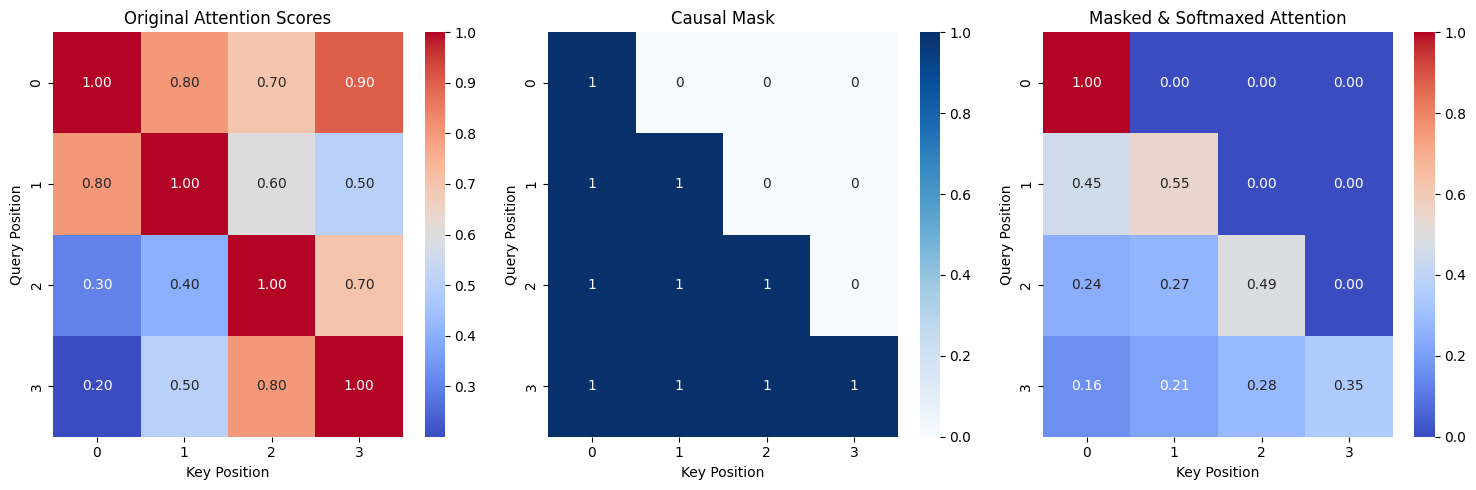

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create sample attention scores
seq_len = 4
scores = torch.tensor([
    [1.0, 0.8, 0.7, 0.9],
    [0.8, 1.0, 0.6, 0.5],
    [0.3, 0.4, 1.0, 0.7],
    [0.2, 0.5, 0.8, 1.0]
])

# Create causal mask (can't look at future tokens)
mask = torch.tril(torch.ones(seq_len, seq_len))

# Visualize original scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(scores, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Original Attention Scores')
plt.xlabel('Key Position')
plt.ylabel('Query Position')

# Visualize mask
plt.subplot(1, 3, 2)
sns.heatmap(mask, annot=True, fmt='.0f', cmap='Blues')
plt.title('Causal Mask')
plt.xlabel('Key Position')
plt.ylabel('Query Position')

# Apply mask and visualize
masked_scores = scores.clone()
masked_scores = masked_scores.masked_fill(mask == 0, float('-inf'))
masked_scores = torch.softmax(masked_scores, dim=-1)

plt.subplot(1, 3, 3)
sns.heatmap(masked_scores, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Masked & Softmaxed Attention')
plt.xlabel('Key Position')
plt.ylabel('Query Position')

plt.tight_layout()
plt.show()